# Basic Package Mangement

In [1]:
#install.packages("pacman") # Execute this once.
require(pacman)

Loading required package: pacman
Warning message:
"package 'pacman' was built under R version 3.6.3"

### Clearing and unloading packages

In [123]:
# Run this block, when done coding or before starting coding.
p_unload(all)
detach("package:datasets", unload=TRUE)
rm(list=ls()) # removes all previous stored variables

The following packages have been unloaded:
readxl, mosaic, ggridges, mosaicData, ggformula, ggstance, Matrix, lattice, forcats, stringr, dplyr, purrr, readr, tidyr, tibble, ggplot2, tidyverse, pacman



### Loading packages

In [3]:
pacman::p_load(pacman, tidyverse, mosaic, magrittr)

# Initializing the dataframe

In [4]:
library("readxl")
df <- read_excel("data/DeathsDK160321.xlsx")
df

interval,age,infected,tested,female_deaths,male_deaths,tot_deaths,comorbidity,infected_fem,infected_male,tot_male,tot_fem,tot_num
1,0-9,15400,395142,0,1,1,1,7372,8028,313571,297559,611130
2,10-19,34025,605344,0,0,0,0,16626,17399,348964,331889,680853
3,20-29,41545,688922,0,0,0,0,21296,20249,397572,381907,779479
4,30-39,30514,604186,4,2,6,3,15615,14899,352231,341194,693425
5,40-49,32482,646070,3,4,7,5,17345,15137,376117,375174,751291
6,50-59,31843,660087,21,32,53,37,16507,15336,402188,398825,801013
7,60-69,17558,490990,73,122,195,153,8562,8996,327021,338282,666262
8,70-79,10910,370426,229,395,624,516,5378,5532,272021,300894,572915
9,80-89,5760,140654,441,523,964,784,3330,2430,99560,135830,235390
10,90+,1805,28610,325,220,545,433,1277,528,13237,32228,45455


In [5]:
df_no_sum <- df[-c(11), ]
df_no_sum

interval,age,infected,tested,female_deaths,male_deaths,tot_deaths,comorbidity,infected_fem,infected_male,tot_male,tot_fem,tot_num
1,0-9,15400,395142,0,1,1,1,7372,8028,313571,297559,611130
2,10-19,34025,605344,0,0,0,0,16626,17399,348964,331889,680853
3,20-29,41545,688922,0,0,0,0,21296,20249,397572,381907,779479
4,30-39,30514,604186,4,2,6,3,15615,14899,352231,341194,693425
5,40-49,32482,646070,3,4,7,5,17345,15137,376117,375174,751291
6,50-59,31843,660087,21,32,53,37,16507,15336,402188,398825,801013
7,60-69,17558,490990,73,122,195,153,8562,8996,327021,338282,666262
8,70-79,10910,370426,229,395,624,516,5378,5532,272021,300894,572915
9,80-89,5760,140654,441,523,964,784,3330,2430,99560,135830,235390
10,90+,1805,28610,325,220,545,433,1277,528,13237,32228,45455


### Plotting and testing

In [118]:
# Compute confidence interval around mean using normal approximation
bootstrap_bernoulli <- function(data = df_no_sum, sims = 100000, agegroup) {
    n <- data[data$interval == agegroup, ]$infected # Estimated numbers of infected of a certain agegroup in Denmark.
    p_hat <- data[data$interval == agegroup, ]$tot_deaths / n # The estimated probability of dying with covid-19 in the specifik agegroup.
                          
    # Simulate number of infected of size tested, with probability of dying reapeat k times.
    sample <- replicate(sims, rbinom(1000, n, p_hat))
    # Computing the mean of the simulated observations.
    sample_means <- apply(sample, 2, mean)
    
    return(sample_means)
}

In [117]:
samples_mean = list()
for (i in 1:10) {
    samples_mean[[i]] <- bootstrap_bernoulli(agegroup = i)   
}

In [119]:
quantile(unlist(samples_mean[10]), c(0.025, 0.975))

2.5%   97.5% 
543.787 546.203

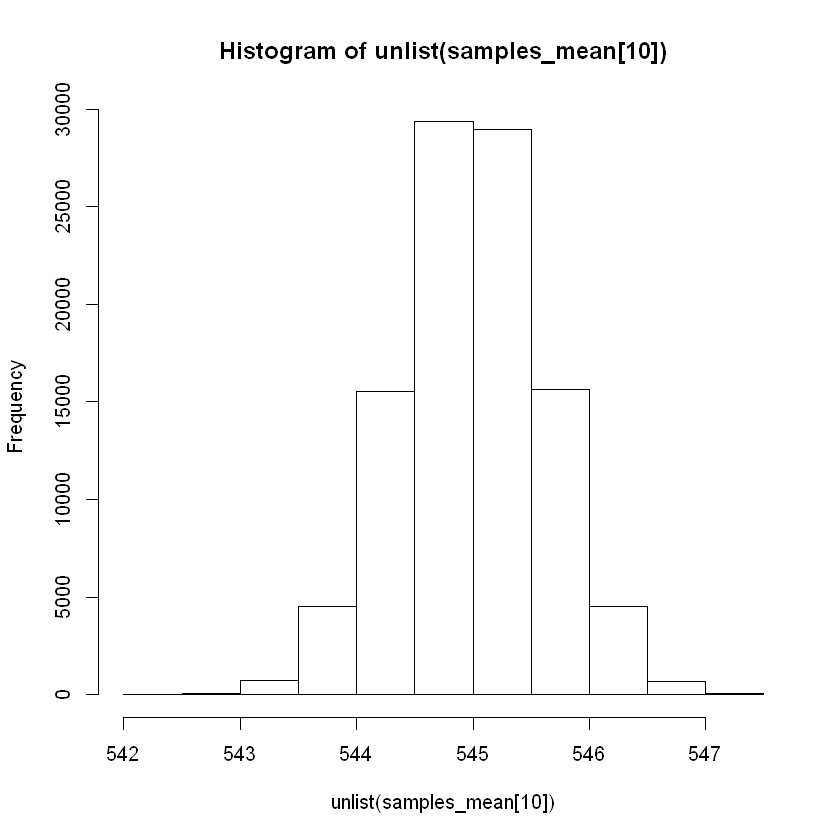

In [120]:
# Plot the result.
hist(unlist(samples_mean[10]))

### Hypotesetest

$H_0:$ Der er ingen signifikant forskel på dødeligheden i de forskellige aldersgrupper.

In [6]:
`p(dead|infected)` = df %>% 
  filter(age != "Alle") %>% 
  select(age, infected, tested, tot_deaths) %>% 
  mutate(`Mortality given Infected` = tot_deaths/infected) %>% 
  rename(Age = age) %>% 
  select(-tested,-tot_deaths)

In [14]:
`p(dead|infected)`

Age,infected,Mortality given Infected
0-9,15400,6.493506e-05
10-19,34025,0.000000e+00
20-29,41545,0.000000e+00
30-39,30514,1.966311e-04
40-49,32482,2.155040e-04
50-59,31843,1.664416e-03
60-69,17558,1.110605e-02
70-79,10910,5.719523e-02
80-89,5760,1.673611e-01
90+,1805,3.019391e-01


In [7]:
Binomial_Bootstrap = function(p,n, B = 10000){
  #Generate new MEAN data
  p_B = rbinom(B,n,p)/n
}

In [8]:
Quantiles_Binomial = `p(dead|infected)` %>% 
  mutate(Bootstraps = map2(`Mortality given Infected`, infected, Binomial_Bootstrap, B = 1000)) %>% 
  mutate(Quantiles = map(Bootstraps, quantile, c(0.025,0.975))) %>% 
  mutate(`2.5% quantile` = unlist(map(Quantiles, function(x){x[1]}))) %>% 
  mutate(`97.5% quantile` = unlist(map(Quantiles, function(x){x[2]}))) %>% 
  select(Age, `2.5% quantile`, `97.5% quantile`)

In [15]:
Quantiles_Binomial

Age,2.5% quantile,97.5% quantile,Bootstrap
0-9,0.000000e+00,0.0001948052,Binomial
10-19,0.000000e+00,0.0000000000,Binomial
20-29,0.000000e+00,0.0000000000,Binomial
30-39,6.554368e-05,0.0003604903,Binomial
40-49,6.157256e-05,0.0003702050,Binomial
50-59,1.256163e-03,0.0021354772,Binomial
60-69,9.568288e-03,0.0127577173,Binomial
70-79,5.316224e-02,0.0613198900,Binomial
80-89,1.576389e-01,0.1776041667,Binomial
90+,2.814404e-01,0.3224376731,Binomial


In [9]:
Bernoulli_Bootstrap = function(p,n, B = 10000){
  #Generate new MEAN data
  p_B = replicate(B,mean(rbernoulli(n,p)))
}

In [19]:
Quantiles_Bernoulli = `p(dead|infected)` %>% 
  mutate(Bootstraps = map2(`Mortality given Infected`, infected, Bernoulli_Bootstrap, B = 1000)) %>% 
  mutate(Quantiles = map(Bootstraps, quantile, c(0.025,0.975))) %>% 
  mutate(`2.5% quantile` = unlist(map(Quantiles, function(x){x[1]}))) %>% 
  mutate(`97.5% quantile` = unlist(map(Quantiles, function(x){x[2]}))) %>% 
  select(Age, `2.5% quantile`, `97.5% quantile`)

In [20]:
Quantiles_Bernoulli

Age,2.5% quantile,97.5% quantile
0-9,0.000000e+00,0.0001948052
10-19,0.000000e+00,0.0000000000
20-29,0.000000e+00,0.0000000000
30-39,6.554368e-05,0.0003604903
40-49,6.157256e-05,0.0004002217
50-59,1.224759e-03,0.0021354772
60-69,9.568288e-03,0.0127577173
70-79,5.288497e-02,0.0615032081
80-89,1.578125e-01,0.1770833333
90+,2.803324e-01,0.3235595568


In [21]:
Quantiles_Bernoulli %<>% mutate(Bootstrap = "Bernoulli")
Quantiles_Binomial %<>% mutate(Bootstrap = "Binomial")

In [22]:
Quantiles = rbind(Quantiles_Bernoulli,Quantiles_Binomial)

In [23]:
Quantiles

Age,2.5% quantile,97.5% quantile,Bootstrap
0-9,0.000000e+00,0.0001948052,Bernoulli
10-19,0.000000e+00,0.0000000000,Bernoulli
20-29,0.000000e+00,0.0000000000,Bernoulli
30-39,6.554368e-05,0.0003604903,Bernoulli
40-49,6.157256e-05,0.0004002217,Bernoulli
50-59,1.224759e-03,0.0021354772,Bernoulli
60-69,9.568288e-03,0.0127577173,Bernoulli
70-79,5.288497e-02,0.0615032081,Bernoulli
80-89,1.578125e-01,0.1770833333,Bernoulli
90+,2.803324e-01,0.3235595568,Bernoulli


Warning message:
"attributes are not identical across measure variables;
they will be dropped"

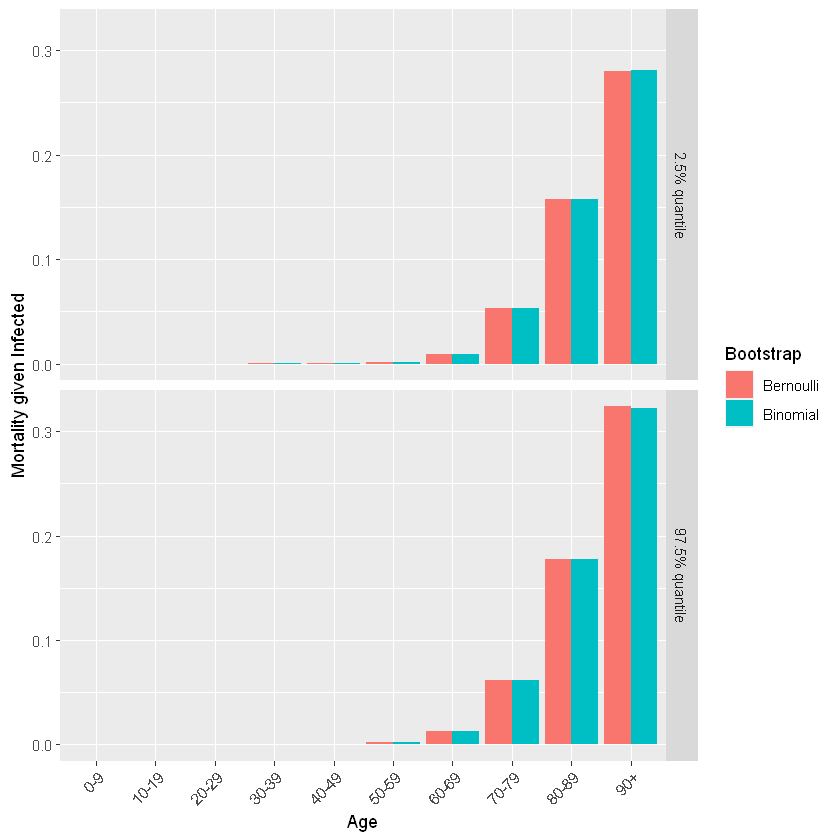

In [24]:
Quantiles %>% gather("Quantile","Value", -Age,-Bootstrap) %>% 
  ggplot(aes(x = Age, y = Value, fill = Bootstrap)) + 
  geom_bar(stat = "identity",position=position_dodge()) + 
  facet_grid(vars(Quantile)) +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) + 
  ylab("Mortality given Infected")

In [1]:
5*5

[1] 25